In [1]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

## Auxillary function declarations 

In [ ]:
cpu = jax.devices("cpu")[0]

Metal device set to: Apple M5

systemMemory: 24.00 GB
maxCacheSize: 8.88 GB



W0000 00:00:1766992438.549265 5594473 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1766992438.562939 5594473 service.cc:145] XLA service 0x8a0c4cd00 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766992438.562951 5594473 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1766992438.564777 5594473 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1766992438.564794 5594473 mps_client.cc:384] XLA backend will use up to 19069206528 bytes on device 0 for SimpleAllocator.


In [2]:
def newton(f, x_0, rtol=1e-8, atol=1e-10, max_iter=50, curr_step=0, prev_min=0):
    """
    Multivariate Newton method with relative error control.
    """
    x = x_0
    f_jac = jax.jacobian(f)

    def newton_step(x):
        Fx = f(x)
        J  = f_jac(x)
        dx = jnp.linalg.solve(J, Fx)
        return x - dx, dx, Fx

    newton_step = jax.jit(newton_step, device=cpu)

    for n in range(1, max_iter + 1):
        x_new, dx, Fx = newton_step(x)

        step_norm = jnp.linalg.norm(dx)
        x_norm    = jnp.linalg.norm(x)
        res_norm  = jnp.linalg.norm(Fx)

        #print(
        #    f"iter {n}: "
        #    f"step = {step_norm:.3e}, "
        #    f"residual = {res_norm:.3e}"
        #)

        # Relative + absolute step criterion
        if step_norm <= atol + rtol * dt * max(1.0, x_norm):
            #print(f"Newton converges after {n} iterations with final step norm {step_norm:.3e} and residual norm {res_norm:.3e}")
            return x_new

        x = x_new


    raise RuntimeError(f"Max iteration reached without convergence at Timestep: {curr_step}, with the minimum h at the previous step: {prev_min}")



In [3]:
# --- flux components ---
def h_xxx(h, dx):
    """Third derivative (periodic)"""
    return (
        jnp.roll(h, -1)
        - 3.0 * h
        + 3.0 * jnp.roll(h, 1)
        - jnp.roll(h, 2)
    ) / dx**3


def f(h, eps):
    h = jnp.maximum(h, 0.0)
    h35 = h**3 * jnp.sqrt(h)   
    return h**4 / (eps + h35)


def a_gs(s1, s2, eps):
    s = 0.5 * (s1 + s2)
    return f(s, eps)


def da_gs(s1, s2, eps):
    s = jnp.maximum(s1 + s2, 0.0)
    s35 = s**3 * jnp.sqrt(s)
    num = 0.5 * s**3 * (4.0 * eps + 0.5 * s35)
    den = (eps + s35)**2
    return num / den



def a_eds(s1, s2, eps):
    h1 = jnp.maximum(s1, 0.0)
    h2 = jnp.maximum(s2, 0.0)

    Gp1 = 2.0 * jnp.sqrt(h1) - eps / (3.0 * h1**3)
    Gp2 = 2.0 * jnp.sqrt(h2) - eps / (3.0 * h2**3)

    num = h1 - h2
    den = Gp1 - Gp2

    # fallback when h1 ~ h2
    a_diag = f(h1, eps)

    return jnp.where(jnp.abs(den) > 1e-14, num / den, a_diag)


# --- Diff schemes ---

@jax.jit
def GS(h, h_curr, dx, dt, eps):
    h_f1 = jnp.roll(h, -1)
    h_b1 = jnp.roll(h, 1)

    f_f12 = a_gs(h,    h_f1, eps) * h_xxx(h_f1, dx)
    f_b12 = a_gs(h_b1, h,    eps) * h_xxx(h,    dx)

    return h - h_curr + (dt / dx) * (f_f12 - f_b12)


@jax.jit
def EDS(h, h_curr, dx, dt, eps):
    h_f1 = jnp.roll(h, -1)
    h_b1 = jnp.roll(h, 1)

    f_f12 = a_eds(h,    h_f1, eps) * h_xxx(h_f1, dx)
    f_b12 = a_eds(h_b1, h,    eps) * h_xxx(h,    dx)

    return h - h_curr + (dt / dx) * (f_f12 - f_b12)





## Coarse grid simulations 

In [ ]:
N = 128
dx = float(1/N)
dt = float(1e-7)
eps = float(1e-11)

x_coarse = jnp.linspace(-1.0, 1.0, N, endpoint=False, dtype=jnp.float64, device=cpu)

h0_coarse = 0.8 - jnp.cos(jnp.pi * x_coarse) + 0.25 * jnp.cos(2.0 * jnp.pi * x_coarse)

# Need to make sure h0_coarse lives on cpu
h0_coarse = jax.device_put(h0_coarse, cpu)

### Solution evolution using the generic scheme with large $\Delta t$

In [6]:
K = 10000
h_curr = h0_coarse

h_min = jnp.min(jnp.abs(h_curr))

sampled_iters = jnp.array([9, 99, 999, 9999])

h_sampled = []

for k in range(K):

    if k % 1000 == 0:
        print(f"Iter {k}")


    F = lambda h: GS(h, h_curr, dx, dt, eps)

    h_next = newton(F, h_curr, rtol=1e-8, atol=1e-10, curr_step=k+1, prev_min=h_min)

    h_min = jnp.min(jnp.abs(h_curr))
    h_curr = h_next

    if k in sampled_iters:
        h_sampled.append(h_curr)


Iter 0


RuntimeError: Max iteration reached without convergence at Timestep: 493, with the minimum h at the previous step: 2.0259796759423338e-05

<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
/var/folders/pb/4lxjhwzj7gjbp6jx2bhl7fwc0000gn/T/ipykernel_88909/2523476018.py:9: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$h_\epsilon(x, t), \ \epsilon=10^{-11}$")


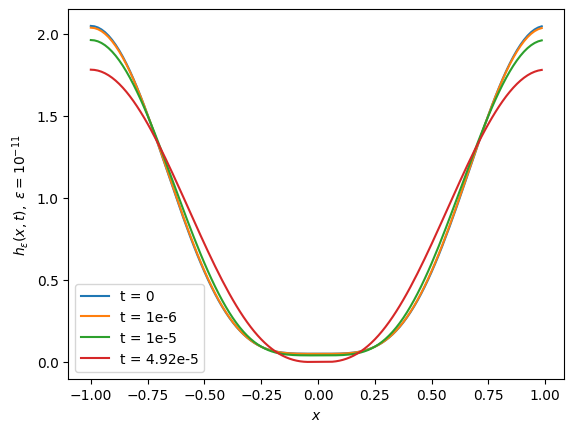

In [7]:
plt.figure()
plt.plot(x_coarse, h0_coarse, label="t = 0")
plt.plot(x_coarse, h_sampled[0], label="t = 1e-6")
plt.plot(x_coarse, h_sampled[1], label="t = 1e-5")
plt.plot(x_coarse, h_curr, label="t = 4.92e-5")
#plt.plot(x_coarse, h_sampled[2], label="t = 1e-4")
#plt.plot(x_coarse, h_sampled[3], label="t = 1e-3")
plt.xlabel("$x$")
plt.ylabel("$h_\epsilon(x, t), \ \epsilon=10^{-11}$")
#plt.axis('equal')
plt.legend()
plt.savefig("sim_results_generic_coarse.png", dpi = 200)

### Solution evolution using the entropy-dissipating scheme with large $\Delta t$

In [8]:
K = 10000
h_curr = h0_coarse

h_min = jnp.min(jnp.abs(h_curr))

sampled_iters = jnp.array([9, 99, 999, 9999])

h_sampled = []

for k in range(K):

    if k % 1000 == 0:
        print(f"Iter {k}")


    F = lambda h: EDS(h, h_curr, dx, dt, eps)

    h_next = newton(F, h_curr, rtol=1e-8, atol=1e-10, curr_step=k+1, prev_min=h_min)

    h_min = jnp.min(jnp.abs(h_curr))
    h_curr = h_next

    if k in sampled_iters:
        h_sampled.append(h_curr)


Iter 0
Iter 1000
Iter 2000
Iter 3000
Iter 4000
Iter 5000
Iter 6000
Iter 7000
Iter 8000
Iter 9000


<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
/var/folders/pb/4lxjhwzj7gjbp6jx2bhl7fwc0000gn/T/ipykernel_88909/3134041935.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$h_\epsilon(x, t), \ \epsilon=10^{-11}$")


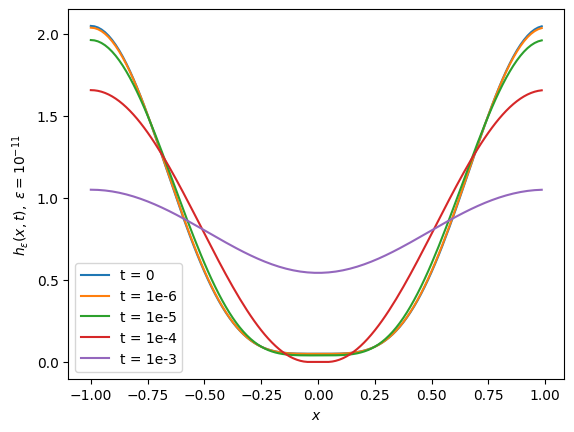

In [9]:
plt.figure()
plt.plot(x_coarse, h0_coarse, label="t = 0")
plt.plot(x_coarse, h_sampled[0], label="t = 1e-6")
plt.plot(x_coarse, h_sampled[1], label="t = 1e-5")
plt.plot(x_coarse, h_sampled[2], label="t = 1e-4")
plt.plot(x_coarse, h_sampled[3], label="t = 1e-3")
plt.xlabel("$x$")
plt.ylabel("$h_\epsilon(x, t), \ \epsilon=10^{-11}$")
#plt.axis('equal')
plt.legend()
plt.savefig("sim_results_eds_coarse.png", dpi = 200)